# Model Evaluation Notebook

This notebook contains the code used to **load the best-trained model** and evaluate its performance on the **test set**. The training process is implemented in [`GarbageClassifier.py`](./GarbageClassifier.py), and [`output_log.out`](./output_log.out) contains the training and validation losses and accuracies per epoch of training.

## Evaluation Includes:
- **Loading the best model** (saved during training).
- **Evaluating the model** on the test dataset.
- **Calculating performance metrics**:  
  - Accuracy  
  - Precision  
  - Recall  
  - F1-score  
- **Plotting a confusion matrix** to analyze classification errors.
- **Plotting ROC curves** to evaluate model discrimination ability.


In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import DistilBertTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

In [2]:
from GarbageClassifier import CustomImageTextDataset, ResNetBERTClassifier

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []  # Store predicted class labels
    all_probs = []  # Store softmax probabilities

    with torch.no_grad():  # No gradient calculation needed
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, input_ids, attention_mask)
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get class predictions

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    accuracy = (torch.tensor(all_labels) == torch.tensor(all_preds)).sum().item() / len(all_labels)

    return {
        'accuracy': accuracy,
        'labels': all_labels,   # Return true labels for confusion matrix
        'predictions': all_preds,  # Return predicted class labels for confusion matrix
        'probabilities': all_probs  # Return softmax probabilities for ROC curve
    }

In [ ]:
# Define test data directory
TEST_PATH   = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"

# Define transformations for the test images
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load dataset
test_dataset = CustomImageTextDataset(TEST_PATH, transform=transform, tokenizer=tokenizer)

# Define dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
# Define the model
model = ResNetBERTClassifier(num_classes=4).to(device)

# Load the best saved model weights
model.load_state_dict(torch.load('./best_model.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Evaluate on the test set
eval_results = evaluate_model(model, test_dataloader, device)

In [7]:
# Print Evaluation Metrics
print("\n--- Evaluation Metrics on Test Set ---\n")
print(f"Test Accuracy        : {eval_results['accuracy']:.4f}")

# Define class names
classes = ['Black', 'Blue', 'Green', 'TTR']

# Generate classification report
report = classification_report(eval_results['labels'], eval_results['predictions'], target_names=classes)

# Print the classification report
print("\nClassification Report:\n")
print(report)


--- Evaluation Metrics on Test Set ---

Test Accuracy        : 0.8508

Classification Report:

              precision    recall  f1-score   support

       Black       0.77      0.74      0.76       695
        Blue       0.84      0.89      0.86      1086
       Green       0.90      0.94      0.92       799
         TTR       0.88      0.81      0.84       852

    accuracy                           0.85      3432
   macro avg       0.85      0.84      0.85      3432
weighted avg       0.85      0.85      0.85      3432



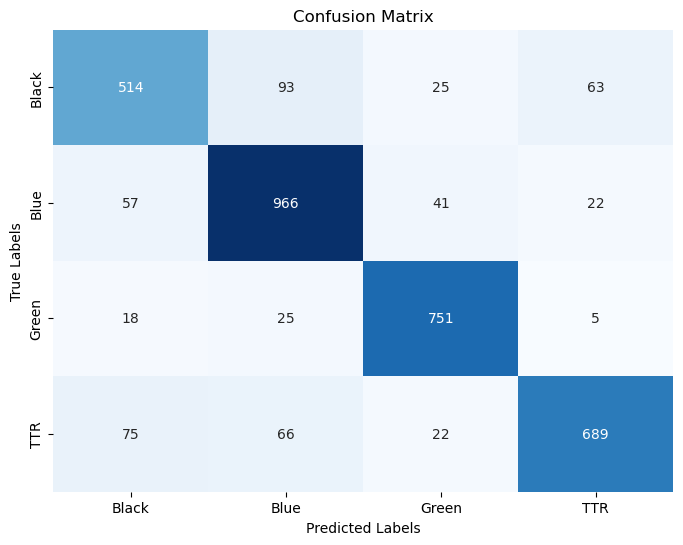

In [8]:
# Plot Confusion Matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Call the function using predictions and true labels
plot_confusion_matrix(eval_results['labels'], eval_results['predictions'], classes)

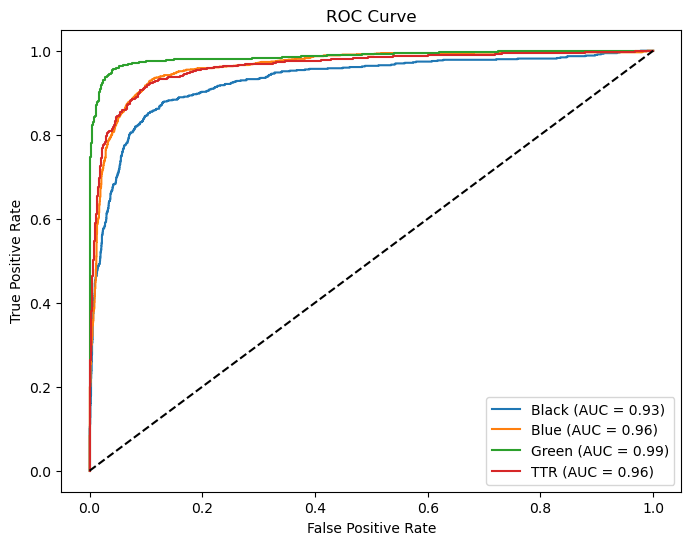

In [9]:
# Plot ROC curve
def plot_roc_curve(true_labels, pred_probs, class_names):
    plt.figure(figsize=(8, 6))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(np.array(true_labels) == i, np.array(pred_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Call the function using true labels and prediction probabilities
plot_roc_curve(eval_results['labels'], eval_results['probabilities'], classes)

Overall, the model exhibits strong generalization to the test set, achieving an 85.08% accuracy. The weighted precision (85%), recall (85%), and F1-score (85%) suggest a well-balanced performance across all classes.

The confusion matrix indicates that most predictions align well with true labels, though some misclassifications persist. Classes 1 (Blue) and 2 (Green) show the highest classification accuracy, whereas Classes 0 (Black) and 3 (TTR) exhibit more misclassification errors.

The ROC curve further confirms strong class seperation, with AUC scores exceeding 0.93 for all classes. Class 2 (Green) achieves the highest AUC (0.99), indicating it is the easiest to classify, while Class 0 (Black) shows slightly more overlap with other classes (AUC = 0.93).

Overall, the model performs well on the test set, demonstrating effective generalization. However, reducing misclassifications in certain categories, particularly Black and TTR, could further improve performance.